# Datenaufbereitung Strassenverkehrsunfaelle für Dashboard auf AGOL
Datum: 14.01.2022

Seit 2020 habe ich auf AGOL ein Dashboard erstellt, welches beim DAV aufgeschalten wird.

- Datenbasis: [**Polizeilich registrierte Verkehrsunfälle auf dem Stadtgebiet Zürich seit 2011**](https://data.stadt-zuerich.ch/dataset/sid_dav_strassenverkehrsunfallorte)
- [**Dashboard (aktuell)**](https://www.arcgis.com/apps/dashboards/f17bc71aa3ec4162a0744a602268dbe8)


Der Projektordner befindet sich auf **O:\GIS\Tools\AGOL\produktive_dashboards\strassenverkehrsunfaelle**




<!---  
Dieses Notebook verwendet als Vorlage die Webseite «[Kitas in Berlin - Jupyter Notebook](https://juanitorduz.github.io/kitas_berlin/)» 
---!>

Mit Colab kann **dieses Jupyter-Notebook interaktiv im Browser** gestartet werden:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DonGoginho/myPy_RIS_API/blob/main/RIS_API_AL_Geschaefte.ipynb)


In [140]:
#%pip install geopandas fiona requests folium mplleaflet contextily

## Importiere notwendige Packages:

In [189]:
import numpy as np
import pandas as pd
import geopandas as gpd
import altair as alt
import fiona
import requests
import mplleaflet
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

pd.options.display.float_format = '{:.8f}'.format
#pd.set_option('display.width', 100)
#pd.set_option('display.max_columns', 15)

import datetime
import time

In [322]:
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")

**Inhaltsverzeichnis:**

AGOL braucht komischerweise ein csv in wgs84 mit entsprechenden xy-Werten. Das geht besser als direkt ein geoJSON... was erstaunlich ist. 
Aber ja, daher gehen wir wie folgt vor:

1. [Daten importieren](#LiesDatenein): Das csv wird weiter bearbeitet. Vom GeoJSON übernehmen wir XY in WGS84 und joinen es via UID.
2. [Daten aufbereiten](#)
3. [Daten exportieren](#Explorative_Analyse)



## Lies Daten ein


### Importiere die NEU gelieferten Daten als CSV oder als JSON vom Filer

- Link [**Polizeilich registrierte Verkehrsunfälle auf dem Stadtgebiet Zürich seit 2011**](https://data.stadt-zuerich.ch/dataset/sid_dav_strassenverkehrsunfallorte/)



#### Importiere das GeoJSON

Importiere das veröffentlichte GeoJSON und lies es in einen GeoDataFrame ein.

In [142]:
json_fp = r"\\szh\ssz\applikationen\OGD\Daten\Quelldaten\SID\DAV\strassenverkehrsunfaelle\dataprep\datenlieferungen\RoadTrafficAccidentLocations.json"
gdf_geojson_RoadTrafficAccidentLocations = gpd.read_file(json_fp)
print('done')

done


In [143]:
#gdf_geojson_RoadTrafficAccidentLocations.head(1)
#df_geojson_RoadTrafficAccidentLocations.dtypes
gdf_xy_wgs84_geojson_epsg4326 = gdf_geojson_RoadTrafficAccidentLocations.set_crs('epsg:4326')

Schau dir die Koordinatenwerte an

In [144]:
gdf_xy_wgs84_geojson = gdf_xy_wgs84_geojson_epsg4326[['AccidentUID','AccidentLocation_CHLV95_E','AccidentLocation_CHLV95_N','geometry']]
gdf_xy_wgs84_geojson.head(1)

,AccidentUID,AccidentLocation_CHLV95_E,AccidentLocation_CHLV95_N,geometry
0,A2D2677533867004E0430A865E337004,2684605,1245194,POINT Z (8.55841 47.35217 0.00000)


Lies die X und Y Koordinaten aus dem `geometry`Objekt aus

In [145]:
gdf_xy_wgs84_geojson["x"]= gdf_xy_wgs84_geojson['geometry'].x
gdf_xy_wgs84_geojson["y"] = gdf_xy_wgs84_geojson['geometry'].y
gdf_xy_wgs84_geojson[['x', 'y', 'AccidentUID','geometry']].head(1)

C:\ProgramData\Anaconda3\envs\gis_env\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,x,y,AccidentUID,geometry
0,8.55841025,47.35216770,A2D2677533867004E0430A865E337004,POINT Z (8.55841 47.35217 0.00000)


#### Importiere das CSV vom Internet

Das importierte CSV ist noch ein normaler DataFrame, kein Geodataframe. Daher müssen wir es noch entsprechend umwandeln.

In [294]:
#Direkter csv-Import
csv_fp = r"\\szh\ssz\applikationen\OGD\Daten\Quelldaten\SID\DAV\strassenverkehrsunfaelle\dataprep\datenlieferungen\RoadTrafficAccidentLocations.csv"
df_RoadTrafficAccidentLocations = pd.read_csv(csv_fp, sep=',')
print('done')

done


Es gibt einige fehlende Angaben in AccidentHour, daher setzt Python dort dtype als float. Was nicht so schön ist. Daher ersetzen wir es hier.

In [297]:
#Welche Records sind davon betroffen?
#df_RoadTrafficAccidentLocations[df_RoadTrafficAccidentLocations['AccidentHour'].isna()]
df_RoadTrafficAccidentLocations.AccidentHour = df_RoadTrafficAccidentLocations.AccidentHour.astype('Int64')

In [300]:
df_RoadTrafficAccidentLocations.head(1)
#df_RoadTrafficAccidentLocations.dtypes

,AccidentUID,AccidentType,AccidentType_de,AccidentType_fr,AccidentType_it,AccidentType_en,AccidentSeverityCategory,AccidentSeverityCategory_de,AccidentSeverityCategory_fr,AccidentSeverityCategory_it,...,AccidentMonth_fr,AccidentMonth_it,AccidentMonth_en,AccidentWeekDay,AccidentWeekDay_de,AccidentWeekDay_fr,AccidentWeekDay_it,AccidentWeekDay_en,AccidentHour,AccidentHour_text
0,A2D2677533867004E0430A865E337004,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o per colpa propria,Accident with skidding or self-accident,as4,Unfall mit Sachschaden,accident avec dommages matériels,Incidente con danni materiali,...,janvier,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,0,00h-01h


##### Wandle den Dataframe nun in einen Geodataframe um

In [301]:
gdf_from_csv = gpd.GeoDataFrame(
    df_RoadTrafficAccidentLocations, geometry=gpd.points_from_xy(df_RoadTrafficAccidentLocations.AccidentLocation_CHLV95_E, df_RoadTrafficAccidentLocations.AccidentLocation_CHLV95_N))

<AxesSubplot:>

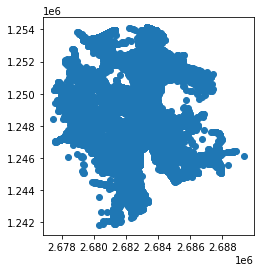

In [302]:
gdf_from_csv.plot()


##### Setze dem Dataframe ein CRS, damit räumliche Operationen überhaupt möglich werden

Initial ist noch nichts gesetzt.

In [303]:
gdf_from_csv.crs is None

True

Mit `set_crs()` wird die das Koordinaten Referenzsystem gesetzt. [Siehe hier](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.set_crs.html#)

In [304]:
gdf_from_csv = gdf_from_csv.set_crs('epsg:2056')

In [305]:
gdf_from_csv.crs is None

False

Prüfe kurz, ob es funktioniert hat.

gdf_from_csv.crs

##### Exportiere ein Geopackage in LV95

Das Geopackage wird von uns als **Zusatzleistung** erstellt, damit es nebst dem geojson in wgs84 noch ein weiteres Geoformat in LV95 gibt.

In [342]:
gdf_from_csv.to_file(r"\\szh\ssz\applikationen\OGD\Daten\Quelldaten\SID\DAV\strassenverkehrsunfaelle\dataprep\datenoutput\RoadTrafficAccidentLocations_"+date_today+".gpkg", driver="GPKG")
#countries_gdf.to_file("package.gpkg", layer='countries', driver="GPKG")

##### Wandle die Koordinaten von LV95 zu WGS84 um und lies die XY-Werte aus

In [307]:
gdf_from_csv2epsg4326 = gdf_from_csv.to_crs('epsg:4326')

In [308]:
#gdf_from_csv2epsg4326.crs

In [309]:
gdf_from_csv2epsg4326["X"] = gdf_from_csv2epsg4326['geometry'].x
gdf_from_csv2epsg4326["Y"] = gdf_from_csv2epsg4326['geometry'].y
gdf_from_csv2epsg4326[['X', 'Y', 'AccidentUID']].head(1)

,X,Y,AccidentUID
0,8.55841025,47.35216770,A2D2677533867004E0430A865E337004


Prüfe kurz, ob es unterschiede zwischen den GeoJSON- und den umgewandelten CSV-Werten gibt

In [310]:
compare = gdf_from_csv2epsg4326[['X', 'Y', 'AccidentUID']].merge(gdf_xy_wgs84_geojson[['x', 'y', 'AccidentUID','geometry']], on=['AccidentUID'])
compare.head(2)

,X,Y,AccidentUID,x,y,geometry
0,8.55841025,47.35216770,A2D2677533867004E0430A865E337004,8.55841025,47.35216770,POINT Z (8.55841 47.35217 0.00000)
1,8.52932024,47.36851152,9FD6441F802C20A6E0430A865E3320A6,8.52932024,47.36851152,POINT Z (8.52932 47.36851 0.00000)


## Erweitere die ursprüngliche Struktur des CSV-Files

Das File welches auf ArcGIS-Online hochgeladen wird, benötigt weitere Attribute. 

- Einerseits `myDate`(Jahr und Monat als String) und 
- `AmtAcc`(Wird zur Summierung von Fällen benötigt)

In [315]:
#gdf_from_csv2epsg4326.head(1)

In [317]:
gdf_from_csv2epsg4326 = gdf_from_csv2epsg4326.assign(
    myDate=lambda x: x.AccidentYear.astype(str)+'-'+ x.AccidentMonth.astype(str)
    ,AmtAcc=lambda x: 1
).sort_values('AccidentUID', ascending=False)

gdf_from_csv2epsg4326.head(2)
#gdf_from_csv2epsg4326.dtypes


,AccidentUID,AccidentType,AccidentType_de,AccidentType_fr,AccidentType_it,AccidentType_en,AccidentSeverityCategory,AccidentSeverityCategory_de,AccidentSeverityCategory_fr,AccidentSeverityCategory_it,...,AccidentWeekDay_fr,AccidentWeekDay_it,AccidentWeekDay_en,AccidentHour,AccidentHour_text,geometry,X,Y,myDate,AmtAcc
13036,FFF3DE2EAFF5001CE0430A83942701D2,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o per colpa propria,Accident with skidding or self-accident,as3,Unfall mit Leichtverletzten,accident avec blessés légers,Incidente con feriti leggeri,...,mercredi,Mercoledì,Wednesday,23,23h-00h,POINT (8.51959 47.38748),8.51958934,47.38748371,2014-8,1
12748,FFF3330135F400A0E0430A8394270304,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o per colpa propria,Accident with skidding or self-accident,as4,Unfall mit Sachschaden,accident avec dommages matériels,Incidente con danni materiali,...,samedi,Sabato,Saturday,18,18h-19h,POINT (8.50632 47.42835),8.50631551,47.42835446,2014-7,1


### Ordne die Reihenfolge der Attribute neu

In [318]:
gdf_from_csv2epsg4326.columns

Index(['AccidentUID', 'AccidentType', 'AccidentType_de', 'AccidentType_fr',
       'AccidentType_it', 'AccidentType_en', 'AccidentSeverityCategory',
       'AccidentSeverityCategory_de', 'AccidentSeverityCategory_fr',
       'AccidentSeverityCategory_it', 'AccidentSeverityCategory_en',
       'AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle',
       'AccidentInvolvingMotorcycle', 'RoadType', 'RoadType_de', 'RoadType_fr',
       'RoadType_it', 'RoadType_en', 'AccidentLocation_CHLV95_E',
       'AccidentLocation_CHLV95_N', 'CantonCode', 'MunicipalityCode',
       'AccidentYear', 'AccidentMonth', 'AccidentMonth_de', 'AccidentMonth_fr',
       'AccidentMonth_it', 'AccidentMonth_en', 'AccidentWeekDay',
       'AccidentWeekDay_de', 'AccidentWeekDay_fr', 'AccidentWeekDay_it',
       'AccidentWeekDay_en', 'AccidentHour', 'AccidentHour_text', 'geometry',
       'X', 'Y', 'myDate', 'AmtAcc'],
      dtype='object')

In [319]:
    column_order = ['X', 'Y','AccidentUID', 'AccidentType', 'AccidentType_de', 'AccidentType_fr','AccidentType_it'
                    , 'AccidentType_en', 'AccidentSeverityCategory','AccidentSeverityCategory_de', 'AccidentSeverityCategory_fr','AccidentSeverityCategory_it'
                    , 'AccidentSeverityCategory_en','AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle','AccidentInvolvingMotorcycle'
                    , 'RoadType', 'RoadType_de', 'RoadType_fr','RoadType_it', 'RoadType_en', 'AccidentLocation_CHLV95_E','AccidentLocation_CHLV95_N'
                    , 'CantonCode', 'MunicipalityCode','AccidentYear', 'AccidentMonth', 'AccidentMonth_de', 'AccidentMonth_fr','AccidentMonth_it'
                    , 'AccidentMonth_en', 'AccidentWeekDay','AccidentWeekDay_de', 'AccidentWeekDay_fr', 'AccidentWeekDay_it','AccidentWeekDay_en'
                    , 'AccidentHour', 'AccidentHour_text', 'geometry','myDate', 'AmtAcc'
    ]
    
input_arcgis_my_RoadTrafficAccidentLocations_wgs84 = gdf_from_csv2epsg4326.reindex(columns=column_order)
input_arcgis_my_RoadTrafficAccidentLocations_wgs84.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 48021 entries, 13036 to 12815
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   X                            48021 non-null  float64 
 1   Y                            48021 non-null  float64 
 2   AccidentUID                  48021 non-null  object  
 3   AccidentType                 48021 non-null  object  
 4   AccidentType_de              48021 non-null  object  
 5   AccidentType_fr              48021 non-null  object  
 6   AccidentType_it              48021 non-null  object  
 7   AccidentType_en              48021 non-null  object  
 8   AccidentSeverityCategory     48021 non-null  object  
 9   AccidentSeverityCategory_de  48021 non-null  object  
 10  AccidentSeverityCategory_fr  48021 non-null  object  
 11  AccidentSeverityCategory_it  48021 non-null  object  
 12  AccidentSeverityCategory_en  48021 non-null  obj

### Exportiere das File in das entsprechende Verzeichnis

In [340]:
input_arcgis_my_RoadTrafficAccidentLocations_wgs84.drop('geometry',axis=1).to_csv(
    r'\\szh\ssz\applikationen\OGD\Daten\Quelldaten\SID\DAV\strassenverkehrsunfaelle\dataprep\datenoutput\agol\input_arcgis_my_RoadTrafficAccidentLocations_wgs84_'+date_today+'.csv'
    , sep=','
    ,index=True
    ,index_label="Beob."
    ,quoting=2
)
#quotechar='"'

Fertig

Lade den Output von hier dann auf AGOL und aktualsiere den Feature Layer. Dann sollte alles gehen.